In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/small-nice-data-dota2/small_nice_data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb

In [3]:
df = pd.read_csv("/kaggle/input/small-nice-data-dota2/small_nice_data.csv",
                 index_col=0)

df.head()

,time,radiant_roshankill,radiant_Δroshankill,dire_roshankill,dire_Δroshankill,good_tower1,good_tower2,good_tower3,good_melee,good_range,...,radiant_buyback,dire_buyback,radiant_Δrunes,dire_Δrunes,radiant_runes,dire_runes,radiant_aegis,dire_aegis,radiantΔaegis,direΔaegis
0,0,0,0,0,0,3,3,3,3,3,...,0,0,1,1,1,1,0,0,0,0
1,60,0,0,0,0,3,3,3,3,3,...,0,0,1,1,2,2,0,0,0,0
2,120,0,0,0,0,3,3,3,3,3,...,0,0,0,0,2,2,0,0,0,0
3,180,0,0,0,0,3,3,3,3,3,...,0,0,0,0,2,2,0,0,0,0
4,240,0,0,0,0,3,3,3,3,3,...,0,0,0,0,2,2,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164300 entries, 0 to 164742
Data columns (total 83 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   time                       164300 non-null  int64  
 1   radiant_roshankill         164300 non-null  int64  
 2   radiant_Δroshankill        164300 non-null  int64  
 3   dire_roshankill            164300 non-null  int64  
 4   dire_Δroshankill           164300 non-null  int64  
 5   good_tower1                164300 non-null  int64  
 6   good_tower2                164300 non-null  int64  
 7   good_tower3                164300 non-null  int64  
 8   good_melee                 164300 non-null  int64  
 9   good_range                 164300 non-null  int64  
 10  good_fort                  164300 non-null  int64  
 11  bad_tower1                 164300 non-null  int64  
 12  bad_tower2                 164300 non-null  int64  
 13  bad_tower3                 164300 

In [5]:
pd.set_option('display.max_columns', None) 
df.describe(include='all')

,time,radiant_roshankill,radiant_Δroshankill,dire_roshankill,dire_Δroshankill,good_tower1,good_tower2,good_tower3,good_melee,good_range,good_fort,bad_tower1,bad_tower2,bad_tower3,bad_melee,bad_range,bad_fort,id,y,radiant_xp_t,dire_xp_t,radiant_Δxp_t,dire_Δxp_t,radiant_gold_t,dire_gold_t,radiant_Δgold_t,dire_Δgold_t,radiant_dn_t,dire_dn_t,radiant_Δdn_t,dire_Δdn_t,radiant_lh_t,dire_lh_t,radiant_Δlh_t,dire_Δlh_t,radiant_artifact_count,dire_artifact_count,radiant_common_count,dire_common_count,radiant_component_count,dire_component_count,radiant_consumable_count,dire_consumable_count,radiant_epic_count,dire_epic_count,radiant_rare_count,dire_rare_count,radiant_secret_shop_count,dire_secret_shop_count,radiant_null_count,dire_null_count,radiant_artifact_cost,dire_artifact_cost,radiant_common_cost,dire_common_cost,radiant_component_cost,dire_component_cost,radiant_consumable_cost,dire_consumable_cost,radiant_epic_cost,dire_epic_cost,radiant_rare_cost,dire_rare_cost,radiant_secret_shop_cost,dire_secret_shop_cost,radiant_null_cost,dire_null_cost,radiant_Δkills,dire_Δkills,radiant_kills,dire_kills,radiant_Δbuyback,dire_Δbuyback,radiant_buyback,dire_buyback,radiant_Δrunes,dire_Δrunes,radiant_runes,dire_runes,radiant_aegis,dire_aegis,radiantΔaegis,direΔaegis
count,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,1.643000e+05,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000,164300.000000
mean,1072.197079,0.285813,0.022069,0.197663,0.016932,1.661540,2.553670,2.872051,2.906032,2.916226,0.985575,1.563329,2.494041,2.862733,2.902392,2.908466,0.984717,5.664784e+09,0.511461,40864.661832,40958.252392,2569.226196,2571.907894,33897.338777,33827.098588,2013.388016,2008.758710,27.216458,25.997407,0.999890,0.957572,403.984540,409.840335,22.391467,22.711059,1.220310,1.229927,18.124601,17.964833,39.539696,39.377121,67.206756,67.229811,1.874881,1.912282,4.990359,4.925673,2.493542,2.513883,0.258296,0.245466,3280.546105,3303.400791,8073.942453,8004.681345,17685.440414,17652.175867,4176.630676,4183.445679,6843.081254,6962.931376,8561.266738,8435.748144,3699.420876,3724.964090,258.295800,245.465612,0.806981,0.792331,12.482483,12.199519,0.056433,0.055411,0.438497,0.423177,0.606409,0.596884,11.661236,11.479075,0.274583,0.187182,0.021272,0.016196
std,734.369752,0.607209,0.146910,0.491219,0.129019,1.229113,0.879006,0.467094,0.397592,0.376865,0.119234,1.230262,0.939335,0.474752,0.394714,0.387845,0.122677,3.554263e+07,0.499870,36539.337077,36703.934215,2077.080414,2084.774993,28055.401652,28114.593978,1093.915103,1100.456804,15.977148,15.552295,1.734774,1.671708,326.291538,334.636517,12.369299,12.756814,1.541215,1.552207,12.249237,12.318169,18.305098,18.285357,39.245670,39.577696,2.745388,2.826218,4.486229,4.415846,3.582302,3.602160,0.563145,0.543812,4538.527850,4569.751600,4625.242045,4614.441725,12111.603428,12143.070895,2583.693774,2598.074132,10616.866188,10872.611295,9588.481439,9366.641293,5887.101933,5860.251696,563.144592,543.811908,1.120726

In [6]:
df['id'].nunique()

4838

In [7]:
y = df['time']
X = df.drop(columns='time')

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [10]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

# числові ознаки
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

# категоріальні ознаки
cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OneHotEncoder(sparse_output=False))
           ])

# об'єднання двох pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor
     

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['radiant_roshankill', 'radiant_Δroshankill', 'dire_roshankill',
       'dire_Δroshankill', 'good_tower1', 'good_tower2', 'good_tower3',
       'good_melee', 'good_range', 'good_fort', 'bad_tower1', 'bad_tower2',
       'bad_tower3', 'bad_melee', 'bad_range', 'bad_fort', 'id', 'y...
       'radiant_kills', 'dire_kills', 'radiant_Δbuyback', 'dire_Δbuyback',
       'radiant_buyback', 'dire_buyback', 'radiant_Δrunes', 'dire_Δrunes',
       'radiant_runes', 'dire_runes', 'radiant_aegis', 'dire_aegis',
       'radiantΔaegis', 'direΔaegis'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 Index([], dtype='object'))])

In [11]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [12]:
model = lgb.LGBMRegressor(objective='mse',
                          n_estimators = 30)

In [13]:
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_names = ['test', 'train'],
          eval_metric='mae')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8357
[LightGBM] [Info] Number of data points in the train set: 131440, number of used features: 82
[LightGBM] [Info] Start training from score 1072.303256


LGBMRegressor(n_estimators=30, objective='mse')

In [14]:
def lgbm_r2(y_true, y_pred):
    r2 = metrics.r2_score(y_true, y_pred)
    return "r2", r2, True

In [15]:
from sklearn import metrics

def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [16]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,43.70,43.74
RMSE,58.95,59.49
R2,0.99,0.99


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

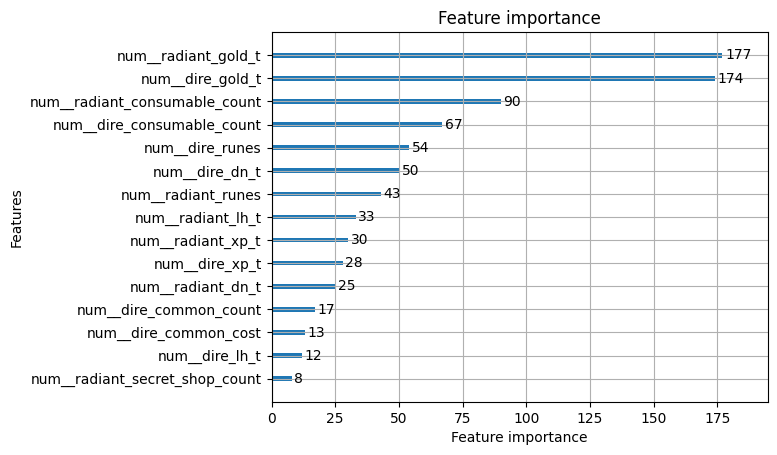

In [17]:
lgb.plot_importance(model, max_num_features=15)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

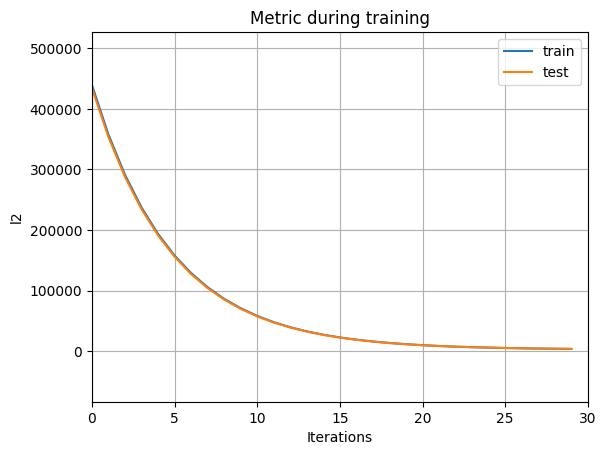

In [18]:
lgb.plot_metric(model,
                metric='l2')

In [19]:
model = Pipeline(
    [("prep", preprocessor),
     ("model", model)
     ]
)

model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['radiant_roshankill', 'radiant_Δroshankill', 'dire_roshankill',
       'dire_Δroshankill', 'good_tower1', 'good_tower2', 'good_tower3',
       'good_melee', 'good_range', 'good_fort', 'bad_tower1', 'bad_tower2',
       'bad_tower3', 'bad_melee', 'bad_r...
       'radiant_buyback', 'dire_buyback', 'radiant_Δrunes', 'dire_Δrunes',
       'radiant_runes', 'dire_runes', 'radiant_aegis', 'dire_aegis',
       'radiantΔaegis', 'direΔaegis'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  Index([], dtype='object'))])),
                ('model', LGBMRegressor(n_estimators=30, objective='mse'))])

In [20]:
import joblib
joblib.dump(model, 'my_model.pkl')

['my_model.pkl']

In [21]:
data = df.sample(1)
data

,time,radiant_roshankill,radiant_Δroshankill,dire_roshankill,dire_Δroshankill,good_tower1,good_tower2,good_tower3,good_melee,good_range,good_fort,bad_tower1,bad_tower2,bad_tower3,bad_melee,bad_range,bad_fort,id,y,radiant_xp_t,dire_xp_t,radiant_Δxp_t,dire_Δxp_t,radiant_gold_t,dire_gold_t,radiant_Δgold_t,dire_Δgold_t,radiant_dn_t,dire_dn_t,radiant_Δdn_t,dire_Δdn_t,radiant_lh_t,dire_lh_t,radiant_Δlh_t,dire_Δlh_t,radiant_artifact_count,dire_artifact_count,radiant_common_count,dire_common_count,radiant_component_count,dire_component_count,radiant_consumable_count,dire_consumable_count,radiant_epic_count,dire_epic_count,radiant_rare_count,dire_rare_count,radiant_secret_shop_count,dire_secret_shop_count,radiant_null_count,dire_null_count,radiant_artifact_cost,dire_artifact_cost,radiant_common_cost,dire_common_cost,radiant_component_cost,dire_component_cost,radiant_consumable_cost,dire_consumable_cost,radiant_epic_cost,dire_epic_cost,radiant_rare_cost,dire_rare_cost,radiant_secret_shop_cost,dire_secret_shop_cost,radiant_null_cost,dire_null_cost,radiant_Δkills,dire_Δkills,radiant_kills,dire_kills,radiant_Δbuyback,dire_Δbuyback,radiant_buyback,dire_buyback,radiant_Δrunes,dire_Δrunes,radiant_runes,dire_runes,radiant_aegis,dire_aegis,radiantΔaegis,direΔaegis
50878,1740,1,0,0,0,1,3,3,3,3,1,0,1,3,3,3,1,5643829904,1,70403.0,76348.0,2447.0,1709.0,60234.0,57144.0,2207.0,2455.0,34.0,36.0,0.0,0.0,671.0,737.0,30.0,26.0,2.0,3.0,26.0,25.0,54.0,58.0,90.0,90.0,3.0,3.0,8.0,8.0,3.0,5.0,1.0,0.0,8300.0,5875.0,13210.0,12100.0,31125.0,31315.0,5480.0,5065.0,10450.0,13705.0,16350.0,17550.0,4100.0,8400.0,1000.0,0.0,0,1,21,20,0,0,0,1,0,1,23,15,1,0,0,0


In [22]:
model.predict(data)

array([1665.09351092])